In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering

rating = pd.read_csv('./ratings_drop.csv' , usecols=[ 'userId' , 'productId' , 'rating'] )
products = pd.read_csv('./products_join_categories.csv')
products = products.loc[:, ~products.columns.str.contains('^Unnamed')]
products.set_index( ['productId'] , inplace=True, drop=True )
products = products.rename({'name': 'product_name'}, axis='columns')
display(products.head())

,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name
productId,,,,,,,,
0,CSSMs Biology: Control in Cells and in Organis...,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
1,Treasure Island,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿
2,Collins Primary Dictionaries – Collins Junior ...,"832,476,739",832,图书音像,476,其它图书,739.0,工具书
3,Partners in Crime,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
4,The Hobbit,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿


In [54]:
display(rating.head())

,userId,productId,rating
0,15905.0,452609,5.0
1,94522.0,452609,5.0
2,317087.0,452609,5.0
3,1329103.0,452609,5.0
4,502593.0,452609,5.0


In [55]:
display(rating.describe())

,userId,productId,rating
count,7.202839e+06,7.202921e+06,7.202920e+06
mean,3.368837e+05,2.651382e+05,4.277313e+00
std,3.619076e+05,1.525959e+05,1.060728e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.653000e+04,1.331870e+05,4.000000e+00
50%,1.915990e+05,2.667810e+05,5.000000e+00
75%,5.283595e+05,3.965950e+05,5.000000e+00
max,1.424594e+06,5.256180e+05,5.000000e+00


In [56]:
print('No. of Unique Users    :', rating.userId.nunique())
print('No. of Unique Products :', rating.productId.nunique())
print('No. of Unique Ratings  :', rating.rating.nunique())

No. of Unique Users    : 1424595
No. of Unique Products : 525619
No. of Unique Ratings  : 6


In [57]:
ratingViaUserCount = rating.groupby(by=['rating']).agg({'userId': 'count'}).reset_index()
ratingViaUserCount.columns = ['rating', 'Count']

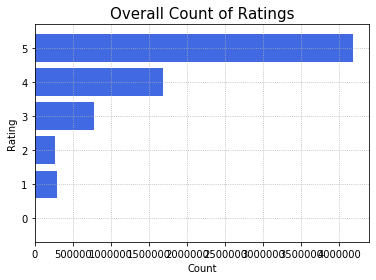

,rating,Count
0,0.0,1
1,1.0,293748
2,2.0,261960
3,3.0,781982
4,4.0,1680574


In [58]:
plt.barh(ratingViaUserCount.rating, ratingViaUserCount.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Rating', fontsize=10)
plt.grid(ls='dotted')
plt.show()
display(ratingViaUserCount.head())

In [59]:
userRatingCount = rating['userId'].value_counts();
ratingFiltered = rating[rating['userId'].isin(userRatingCount[userRatingCount >= 50 ].index)]
print(ratingFiltered.shape)
print(rating.shape)
productRatingCount = rating['productId'].value_counts();
ratingFiltered = ratingFiltered[ratingFiltered['userId'].isin(productRatingCount[productRatingCount >= 100 ].index)]
print(ratingFiltered.shape)

(1847803, 3)
(7202921, 3)
(35024, 3)


In [60]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratingFiltered[['userId', 'productId', 'rating']], reader)

In [61]:
display(products.sample(10))
display(ratingFiltered.sample(10))
display(ratingFiltered.shape)

,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name
productId,,,,,,,,
374581,优秀员工这样工作,"832,151,305",832,图书音像,151,经管类图书,305.0,成功/励志
15408,天利38套2014江苏省高考模拟试题汇编:英语(听力录音另配)(赠江苏考生备考手册网络打印版...,"832,1101,374",832,图书音像,1101,少儿/教育图书,374.0,中小学教辅
291998,新编金融法小全书8,"832,723,160",832,图书音像,723,人文社科类图书,160.0,法律
494337,Hormars红模 春装新款连衣裙 性感修身包臀裙 拼接蕾丝裙子 13203039,"802,681,331",802,服饰服装,681,女装,331.0,连衣裙
318435,Microtek 中晶 ScanMaker s360 彩色平台式扫描仪(黑色),"1057,1094,111",1057,电脑/办公,1094,办公设备/耗材,111.0,扫描仪
73861,GIGABYTE 技嘉P35K-2 超薄商务游戏本(15.6英寸 1920*1080IPS ...,"1057,205,1006",1057,电脑/办公,205,电脑整机,1006.0,笔记本
345976,下午吃块巧克力:重启大脑的30种方法,"832,665,1048",832,图书音像,665,生活类图书,1048.0,烹饪/美食
483993,Sketchbook Black: Archival-Quality Drawing Paper,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
522281,魅力女人的9大资本:做自己的女王,"832,151,305",832,图书音像,151,经管类图书,305.0,成功/励志


,userId,productId,rating
3559410,65650.0,508551,5.0
1569148,15596.0,145541,5.0
6595598,10980.0,296393,5.0
6160335,39977.0,3620,5.0
2707964,5701.0,183418,4.0
5541110,77625.0,464642,4.0
6781561,31004.0,410229,1.0
6118217,4874.0,421,1.0
2379490,5693.0,436745,3.0
5040989,2097.0,350423,5.0


(35024, 3)

In [62]:
print('No. of Unique Users    :', ratingFiltered.userId.nunique())
print('No. of Unique Products :', ratingFiltered.productId.nunique())
print('No. of Unique Ratings  :', ratingFiltered.rating.nunique())
print(products.iloc[1].product_name)

No. of Unique Users    : 241
No. of Unique Products : 22683
No. of Unique Ratings  : 5
Treasure Island


In [63]:
productJoinEdRaiting = pd.merge(products, ratingFiltered, on='productId', how='inner')

In [64]:
display(productJoinEdRaiting.sample(10))

,productId,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name,userId,rating
14882,227332,水浒传(注音美绘本),"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿,7621.0,4.0
2681,37718,面向21世纪课程教材:生物化学(下),"832,1101,379",832,图书音像,1101,少儿/教育图书,379.0,教材,9560.0,4.0
8756,132358,别笑!我是英文单词书,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿,7488.0,2.0
31568,474797,红楼梦,"832,519,1",832,图书音像,519,文学艺术,1.0,小说,1355.0,4.0
4566,67662,小米 2SC MI2SC CDMA2000 16G版 3G手机(白色 电信定制)全新四核1....,"1128,640,304",1128,手机/数码,640,手机通讯,304.0,手机,9560.0,4.0
18962,291469,舞状元 第六代8MM加厚型跳舞毯 电脑电视两用跳舞机 2000首歌曲中文界面无限下载 高清画...,"1111,169,11",1111,运动户外,169,运动器材,11.0,其他运动器材,4624.0,4.0
6507,97859,没有什么能够阻挡,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿,5226.0,5.0
7967,119050,BULL 公牛插座 314 1.8米 单控单开 三位独立开关 365天满负荷不发热,"571,1125,877",571,家具/家装/建材,1125,电子/水电工,877.0,插座,6502.0,5.0
16934,259548,西方人文历史名著导读,"832,723,221",832,图书音像,723,人文社科类图书,221.0,政治/军事,12301.0,5.0
802,10944,"Neutrogena露得清深层柔珠洗面乳100g(新旧包装更替,随机发货)","916,451,406",916,美妆个护,451,面部护理,406.0,洁面,22785.0,4.0


In [65]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    # 首先将预测值映射至每个用户
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
trainset = data.build_full_trainset()
algo = SVD(n_epochs = 500)
algo.fit(trainset)

In [66]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

56597.0 [185856, 412336, 171359, 179221, 387693, 359025, 424691, 407499, 273262, 275516]
56918.0 [456872, 460902, 303194, 303920, 41203, 45458, 370961, 375073, 106329, 433560]
47.0 [430834, 184810, 185856, 203169, 506468, 17453, 199649, 410563, 180927, 51695]
24590.0 [232021, 241796, 228884, 384090, 212117, 179221, 185856, 510199, 50789, 93497]
103250.0 [453473, 453869, 454107, 454331, 454377, 454660, 455317, 455710, 456106, 456138]
5729.0 [308723, 379158, 157264, 179221, 185856, 201640, 203169, 193047, 123379, 148437]
10712.0 [459330, 463018, 299404, 302034, 303194, 308413, 233165, 239585, 239657, 49205]
79411.0 [455143, 456580, 463122, 463839, 464114, 303194, 305105, 307735, 308413, 233183]
391.0 [307698, 241457, 371540, 376461, 345003, 69540, 156103, 437179, 181495, 203169]
953.0 [367460, 339973, 345956, 203606, 343061, 175169, 354733, 294907, 244151, 179221]
18235.0 [41203, 371601, 141313, 221521, 72099, 211616, 217344, 179221, 181781, 203606]
66003.0 [185856, 203606, 9844, 179221,

In [78]:
display(productJoinEdRaiting[productJoinEdRaiting.userId == 56597 ].sort_values(by=['rating' , 'cat1' ] , ascending=False ))

display(products.iloc[412336] )

# display(ratingFiltered[ratingFiltered.userId == 56597 ])

# display(ratingFiltered[ratingFiltered.userId == 185856 ])

# # print(type(testset))
# # print(type(testset[0]))
# # dt=np.dtype('int,int,float')
# # xarr = np.array(testset)
# # print(xarr[:,2].max())
# # print(xarr[:,2].min())
# # print(xarr[:,2][0])
# # xarr[:,2]
# # display(testset)
# temp = ratingFiltered[ratingFiltered.userId == 56592 ]
# display(temp.head())
# temp = temp[temp.productId == 453451]
# display(temp)
# testset = trainset.build_anti_testset()
# display(testset)

,productId,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name,userId,rating
8942,134959,RIDO 力动 仰卧板 多功能腹肌板 健腹板 哑铃折叠仰卧起坐板 带超强力拉绳 高低两用俯卧...,"1111,169,1130",1111,运动户外,169,运动器材,1130.0,中小型健身器材,56597.0,5.0
13913,212449,MERCURY 水星网络 MW150R 11N 150M无线宽带路由器(此款产品老版本为8个...,"1057,390,815",1057,电脑/办公,390,网络设备,815.0,路由器/中继器,56597.0,5.0
3097,44169,Zojirushi 象印 不锈钢真空保温杯车载杯 SM-KA48-BA 480ml 黑色,"933,833,743",933,家居生活,833,厨房/餐具,743.0,保温杯/保温壶,56597.0,5.0
4698,70249,Zojirushi 象印 不锈钢真空保温杯车载杯 SM-KA36-NL 360ml 香槟金色,"933,833,743",933,家居生活,833,厨房/餐具,743.0,保温杯/保温壶,56597.0,5.0
8183,122481,哈尔斯HB-500AX真空保温杯(蓝色),"933,833,743",933,家居生活,833,厨房/餐具,743.0,保温杯/保温壶,56597.0,5.0
8211,122804,Zojirushi 象印 不锈钢真空保温杯车载杯 SM-KA48-AG 480ml 深蓝色,"933,833,743",933,家居生活,833,厨房/餐具,743.0,保温杯/保温壶,56597.0,5.0
13432,204125,飞天 多功能抱枕被子两用靠垫 办公室空调午休被创意靠枕 悠嘻猴,"933,551,562",933,家居生活,551,家纺,562.0,被子,56597.0,5.0
28298,428709,Zojirushi 象印 不锈钢真空保温杯车载杯 SM-KA48-PT 480ml 粉色,"933,833,743",933,家居生活,833,厨房/餐具,743.0,保温杯/保温壶,56597.0,5.0
32012,481185,Zojirushi 象印 不锈钢真空保温杯车载杯 SM-KA36-BA 360ml 黑色,"933,833,743",933,家居生活,833,厨房/餐具,743.0,保温杯/保温壶,56597.0,5.0
33207,497415,Zojirushi 象印 不锈钢真空保温杯车载杯 SM-KA36-AG 360ml 深蓝色,"933,833,743",933,家居生活,833,厨房/餐具,743.0,保温杯/保温壶,56597.0,5.0


product_name        我不是完美小孩
catIds          832,519,164
cat1                    832
cat1_name              图书音像
cat2                    519
cat2_name              文学艺术
cat3                    164
cat3_name             动漫/幽默
Name: 412336, dtype: object

In [44]:
from numpy import *
from numpy import random
import matplotlib.pyplot as plt



ratingFiltered2 = ratingFiltered.drop_duplicates(subset=['userId', 'productId'], keep='first' )
raitingFilteredPivot = ratingFiltered2.pivot( index='userId' , columns='productId' , values="rating" ).fillna(0)

rating_matrix = raitingFilteredPivot
rating_matrix = rating_matrix.to_numpy()
user_num = rating_matrix.shape[0]
item_num = rating_matrix.shape[1]

# initialize user and item matrix with random float between -1 and 1(not included)
feature_num = 2
user_matrix = random.random_sample((user_num, feature_num))
item_matrix = random.random_sample((item_num, feature_num))


def sgd(data_matrix, user, item, alpha, lam, iter_num):
    display(data_matrix)
    for j in range(iter_num):
#         data_matrix.loc[]
        for u in range(data_matrix.shape[0]):
            for i in range(data_matrix.shape[1]):
                if data_matrix[u,i] != 0:
                    e_ui = data_matrix[u,i] - sum(user[u,:] * item[i,:])
                    user[u,:] += alpha * (e_ui * item[i,:] - lam * user[u,:])
                    item[i,:] += alpha * (e_ui * user[u,:] - lam * item[i,:])
    return user, item

user, item = sgd(rating_matrix, user_matrix, item_matrix, 0.001, 0.1, 200)
filter_matrix_entry = rating_matrix <= 0
matrix_predict = dot(user, item.transpose())

# filter the ratings that are already rated
matrix_predict_filtered = matrix_predict * filter_matrix_entry
# save matrix_predict and matrix_predict_filtered to the files respectively
# and make every element correct to two decimal places
savetxt('matrix_predict.txt', matrix_predict, fmt='%.2f')
savetxt('matrix_predict_filtered.txt', matrix_predict_filtered, fmt='%.2f')

# MF for new comer
# randomly initialize the new comer's rate
new_comer_Eric = random.randint(0, 6, size=100)
rating_matrix_new = vstack((rating_matrix, new_comer_Eric))
user_matrix_new = 2 * random.random_sample((user_num+1, feature_num)) - 1
item_matrix_new = 2 * random.random_sample((item_num, feature_num)) - 1
user_new, item_new = sgd(rating_matrix_new, user_matrix_new, item_matrix_new, 0.01, 0.1, 100)
print('The latent feature of new comer(user) is : ', user_new[-1, :])


# let us put bias into the model
# get the overall average rating
def get_miu(data_matrix):

    non_zero_num = 0
    non_zero_sum = 0
    for i in range(data_matrix.shape[0]):
        for j in range(data_matrix.shape[1]):
            if data_matrix[i][j] != 0:
                non_zero_num += 1
                non_zero_sum += data_matrix[i][j]
    return non_zero_sum/non_zero_num, non_zero_num


# the sgd funtion with bias, note that bu and bi shoulde also be trained!(very important)
def sgd_bias(data_matrix, user, item, alpha, lam, iter_num, miu):

    b_u = [1] * rating_matrix.shape[0]
    b_i = [1] * rating_matrix.shape[1]
    for j in range(iter_num):
        for u in range(data_matrix.shape[0]):
            for i in range(data_matrix.shape[1]):
                if data_matrix[u][i] != 0:
                    b_ui = b_u[u] + b_i[i] + miu
                    e_ui = data_matrix[u][i] - b_ui - sum(user[u,:] * item[i,:])
                    user[u,:] += alpha * (e_ui * item[i,:] - lam * user[u,:])
                    item[i,:] += alpha * (e_ui * user[u,:] - lam * item[i,:])
                    b_u[u] += alpha * (e_ui - lam * b_u[u])
                    b_i[i] += alpha * (e_ui - lam * b_i[i])
    return user, item, b_u, b_i

miu, non_zero_num = get_miu(rating_matrix)
print(miu, non_zero_num)
print('the sparse rate of rating matrix is : %.3f' % (non_zero_num/2500))


user_bias, item_bias, b_u, b_i = sgd_bias(rating_matrix, user_matrix, item_matrix, 0.001, 0.1, 1000, miu)
print(user_bias)

# visualize user and item feature
plt.plot(item_bias[:, 0], item_bias[:, 1], 'b*')
plt.plot(user_bias[:, 0], user_bias[:, 1], 'yo')
plt.show()

# calculate MSE
def cal_MSE(data_matrix, predict_matrix, non_zero_num):
    filter_matrix_entry = data_matrix > 0
    predict_matrix_filtered = predict_matrix * filter_matrix_entry
    diff_matrix = (predict_matrix_filtered - data_matrix) * (predict_matrix_filtered - data_matrix)
    mse = (1/non_zero_num) * (diff_matrix.sum())
    return mse

# get the right predictive matrix with bias
matrix_predict_bias = dot(user_bias, item_bias.transpose())
for u in range(matrix_predict_bias.shape[0]):
    for i in range(matrix_predict_bias.shape[1]):
        matrix_predict_bias[u][i] += (miu + b_u[u] + b_i[i])

print(matrix_predict, matrix_predict_bias)
mse = cal_MSE(rating_matrix, matrix_predict, non_zero_num)
mse_bias = cal_MSE(rating_matrix, matrix_predict_bias, non_zero_num)
print('the MSE of the matrix factorization is %.4f' % mse)
print('the MSE of the matrix factorization with considering bias is %.4f' % mse_bias)

array([[5., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

KeyboardInterrupt: 

In [43]:
rating_matrix

productId,4,11,24,31,47,54,115,119,176,180,...,525340,525356,525367,525377,525390,525414,525440,525469,525568,525607
userId,,,,,,,,,,,,,,,,,,,,,
47.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
391.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220617.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223706.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
import sklearn
from sklearn.decomposition import TruncatedSVD

userRatingCount = rating['userId'].value_counts();
ratingFiltered = rating[rating['userId'].isin(userRatingCount[userRatingCount >= 100 ].index)]
print(ratingFiltered.shape)
print(rating.shape)
productRatingCount = rating['productId'].value_counts();
ratingFiltered = ratingFiltered[ratingFiltered['userId'].isin(productRatingCount[productRatingCount >= 150 ].index)]
print(ratingFiltered.shape)


ratingFiltered2 = ratingFiltered.drop_duplicates(subset=['userId', 'productId'], keep='first' )
raitingFilteredPivot = ratingFiltered2.pivot( index='userId' , columns='productId' , values="rating" ).fillna(0)

X = raitingFilteredPivot.values.T
X.shape

SVD = TruncatedSVD(n_components=12, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

(1334724, 3)
(7202921, 3)
(16028, 3)


(11932, 12)

In [19]:
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
corr = np.corrcoef(matrix)
corr.shape

(11932, 11932)

In [21]:
display(corr)

array([[ 1.        , -0.013964  , -0.04012085, ..., -0.00535197,
         0.00748834,  0.25819346],
       [-0.013964  ,  1.        , -0.30863091, ..., -0.13105668,
        -0.54574154,  0.26903053],
       [-0.04012085, -0.30863091,  1.        , ..., -0.15824471,
         0.07146141, -0.18538241],
       ...,
       [-0.00535197, -0.13105668, -0.15824471, ...,  1.        ,
        -0.03194197, -0.1578874 ],
       [ 0.00748834, -0.54574154,  0.07146141, ..., -0.03194197,
         1.        ,  0.18201855],
       [ 0.25819346,  0.26903053, -0.18538241, ..., -0.1578874 ,
         0.18201855,  1.        ]])

In [46]:
display(raitingFilteredPivot.shape)

(56, 11932)

In [36]:
productIds = raitingFilteredPivot.columns
productIdsList = list(productIds)

[47,
 54,
 115,
 119,
 176,
 226,
 280,
 322,
 360,
 391,
 575,
 606,
 615,
 693,
 748,
 858,
 910,
 923,
 953,
 1142,
 1237,
 1300,
 1347,
 1460,
 1469,
 1484,
 1508,
 1521,
 1525,
 1527,
 1601,
 1659,
 1694,
 1763,
 1809,
 1810,
 1859,
 1878,
 1955,
 1973,
 1987,
 2067,
 2097,
 2109,
 2183,
 2262,
 2263,
 2277,
 2281,
 2332,
 2457,
 2467,
 2483,
 2559,
 2583,
 2601,
 2640,
 2681,
 2700,
 2751,
 2764,
 2790,
 2802,
 2853,
 2857,
 2962,
 3060,
 3108,
 3119,
 3121,
 3174,
 3213,
 3225,
 3270,
 3318,
 3324,
 3356,
 3404,
 3528,
 3620,
 3632,
 3785,
 3982,
 4010,
 4051,
 4070,
 4091,
 4095,
 4217,
 4228,
 4234,
 4251,
 4263,
 4329,
 4384,
 4428,
 4595,
 4609,
 4620,
 4624,
 4634,
 4810,
 4835,
 4945,
 5066,
 5200,
 5226,
 5229,
 5268,
 5325,
 5333,
 5363,
 5368,
 5428,
 5467,
 5570,
 5574,
 5596,
 5693,
 5729,
 5843,
 5917,
 5924,
 6031,
 6057,
 6059,
 6116,
 6156,
 6213,
 6267,
 6269,
 6400,
 6423,
 6513,
 6538,
 6611,
 6623,
 6734,
 6755,
 6775,
 6786,
 6797,
 6831,
 6848,
 6881,
 6883,

In [45]:
watchIndex = productIdsList.index(280)
print(products.iloc[280])
corr_coffey_hands  = corr[watchIndex]

# list(productIds[(corr_coffey_hands >= 0.9)])

for i in productIds[(corr_coffey_hands >= 0.9)]:
    print( products.iloc[i].product_name )

# display(productIdsList)
# display(productIdsList[0])

product_name    CASIO 卡西欧 指针Child系列电池防水女表 LQ-139BMV-1B
catIds                                     486,487,706
cat1                                               486
cat1_name                                  钟表/首饰/眼镜/礼品
cat2                                               487
cat2_name                                           钟表
cat3                                               706
cat3_name                                           手表
Name: 280, dtype: object
CASIO 卡西欧 指针Child系列电池防水女表 LQ-139BMV-1B
阳宅三要(套装共3册)
Rapoo 雷柏 3500时尚鹅卵石外形激光鼠标(酷黑)(2.4GHz无线传输技术 USB接口设计 即插即用)
韩国语能力考试语法大纲真题解析和实战训练(中级)
TO-PLAN 日系22055 双层蕾丝立体绣花 两折公主洋伞 黑胶太阳伞 晴雨伞 (银灰)
Mentholatum曼秀雷敦乐肤洁清爽洁面泡沫150ml(特卖)
爱的教育
汪曾祺集:一辈古人
丹杰仕 男士韩版立领格子机车皮衣潮流棉衣棉服 修身款偏小一码813JK201
怒江之战:大结局(赠《听雷》试读本)
Eshow 易秀 【春季新品】 2014新款春季彩色帆布包酷炫休闲女款小挎包BFY000071
动物小说大王沈石溪????品藏书系:第七条猎狗
报海旧闻(修订版)
PARKER派克 卓尔系列纯银格子纹金夹墨水笔(钢笔)(正品行货 品质保证)
MG美即海洋冰泉补水面膜25g*10片(特卖)
Kawasaki 川崎 羽毛球10号(2桶24只装)
Kawasaki 川崎 追风系列 中性 羽毛球鞋 K-001
非常班级系列第1季(套装共6册)
会飞的教室(畅销版)
首信雅器版S718老人手机 (超大按